Don't forget to install cartopy package as it doesn't come with default Python libraries. Install NetCDF4 and H5NetCDF in case of errors from xarray related to those packages.

In [192]:
import xarray as xr
import pandas as pd
import numpy as np
import cartopy as crt
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import warnings

## Reformatting the Data

In [193]:
# If the data is NetCDF format, use xarray instead of NumPy to open the data
rawPrpData = np.fromfile('GPCC_INA.dat', dtype=np.float32)

# The original data is 1-dimensional so we reshape it to 3-dimensional
rawPrpData = np.reshape(rawPrpData, (768, 41, 101))

# This defines coordinate boundaries for Indonesia 
lon = np.linspace(start = 94.75, stop = 94.75 + 100 * 0.5, num = 101)
lat = np.linspace(start = -10.25, stop = -10.25 + 40 * 0.5, num = 41)
time = pd.date_range(start = '1950', periods = 768, freq = 'MS')

# Reform rawPrpData to xarray format for easier processing
precipitationData = xr.DataArray(rawPrpData, dims = ("time", "lat", "lon"), coords = {"time":time, "lat":lat, "lon":lon})
precipitationData = precipitationData.where(precipitationData >= 0)

In [194]:
# Index for the data is imported from external source to define time as index
idx = pd.read_excel('monthly.clim.idx.1948.2015.xlsx')
idx.index = pd.to_datetime(idx['Time'], format = '%Y-%m-%d')
idx = idx.drop(columns = ['Time'])
idx.head()

,AUSMI,ISMI,WNPMI,SOI,DMI
Time,,,,,
1948-01-01,NaN,-4.714674,-7.833619,-0.43,-0.232
1948-02-01,NaN,-7.998664,-8.104503,-0.41,-0.075
1948-03-01,NaN,-8.723557,-5.573905,-0.60,0.125
1948-04-01,NaN,-7.562390,-1.014261,0.26,-0.028
1948-05-01,NaN,-3.001391,2.443265,0.35,-0.005


## Process ENSO and IOD Index

In [195]:
# Store SOI values throughout the time range
soiIdx = idx['SOI'].loc['1950-01-01':'2013-12-01']

# Same as above, but DMI values
dmiIdx = idx['DMI'].loc['1950-01-01':'2013-12-01']

Perhitungan Ambang Batas Curah Hujan
AN = Atas Normal
BN = Bawah Normal

In [196]:
# Calculate climate average of the rainfall. For best practices, climatology mean is averaged from 30 years of data.
climatePrecip = precipitationData.groupby('time.month').mean()

# Calculate anomaly threshold values, usually 15% deviation from climatological average.
aboveNormal = climatePrecip + 0.15 * climatePrecip
belowNormal = climatePrecip - 0.15 * climatePrecip

In [197]:
# Calculate rainfall anomalies
aboveNormalAnomaly = precipitationData.groupby('time.month') - aboveNormal
belowNormalAnomaly = precipitationData.groupby('time.month') - belowNormal

Respon Curah Hujan terhadap kejadian El Nino di DJF
E1 : Kejadian curah hujan di bawah normal
E2 : Kejadian El Nino (SOI >= -1)
P{E1|E2} : Peluang kejadian curah hujan di bawah normal ketika terjadi La Nina

In [198]:
# We group anomaly values by seasons since we want to analyze the difference of rainfall response in different seasons.
seasonANAnomaly = aboveNormalAnomaly.groupby('time.season')

# For other seasons, just change the DJF with MAM, JJA, or SON and re-run the code from here
seasonANAnomaly = seasonANAnomaly['DJF']

# Transform to logical array (0 and 1 values), so if there is anomaly value, will store 1, otherwise store 0.
seasonANAnomaly = (seasonANAnomaly > 0) * 1

In [199]:
# Define SOI threshold to determine ENSO conditions
SOIThreshold = 0.0
seasonSOI = soiIdx.to_xarray().groupby('Time.season')

# For other seasons, just change the DJF with MAM, JJA, or SON
seasonSOI = seasonSOI['DJF']

# Transform to logical array
seasonSOI = (seasonSOI >= SOIThreshold) * 1

In [200]:
# Same code, but takes DMI instead of SOI
seasonANDMIAnomaly = aboveNormalAnomaly.groupby('time.season')
seasonANDMIAnomaly = seasonANDMIAnomaly['DJF']
seasonANDMIAnomaly = (seasonANDMIAnomaly > 0) * 1
DMIThreshold = 0.0
seasonDMI = dmiIdx.to_xarray().groupby('Time.season')
seasonDMI = seasonDMI['DJF']
seasonDMI = (seasonDMI <= DMIThreshold) * 1

In [202]:
# Loop through coordinates to calculate probability of SOI
probabilitySOI = precipitationData[0,...].copy()
nt,ny,nx = precipitationData.shape
for j in range(ny):
    for i in range(nx):
        if ~np.isnan(precipitationData[0, j, i]):
            ts = seasonANAnomaly[:, j, i]
            probabilitySOI[j, i] = np.sum((ts.values & seasonSOI.values)) / np.sum(seasonSOI.values)


In [203]:
# Same, but with DMI
probabilityDMI = precipitationData[0,...].copy()
nt,ny,nx = precipitationData.shape
for j in range(ny):
    for i in range(nx):
        if ~np.isnan(precipitationData[0, j, i]):
            ts = seasonANDMIAnomaly[:, j, i]
            probabilityDMI[j, i] = np.sum((ts.values & seasonDMI.values)) / np.sum(seasonDMI.values)

## Visualization SOI

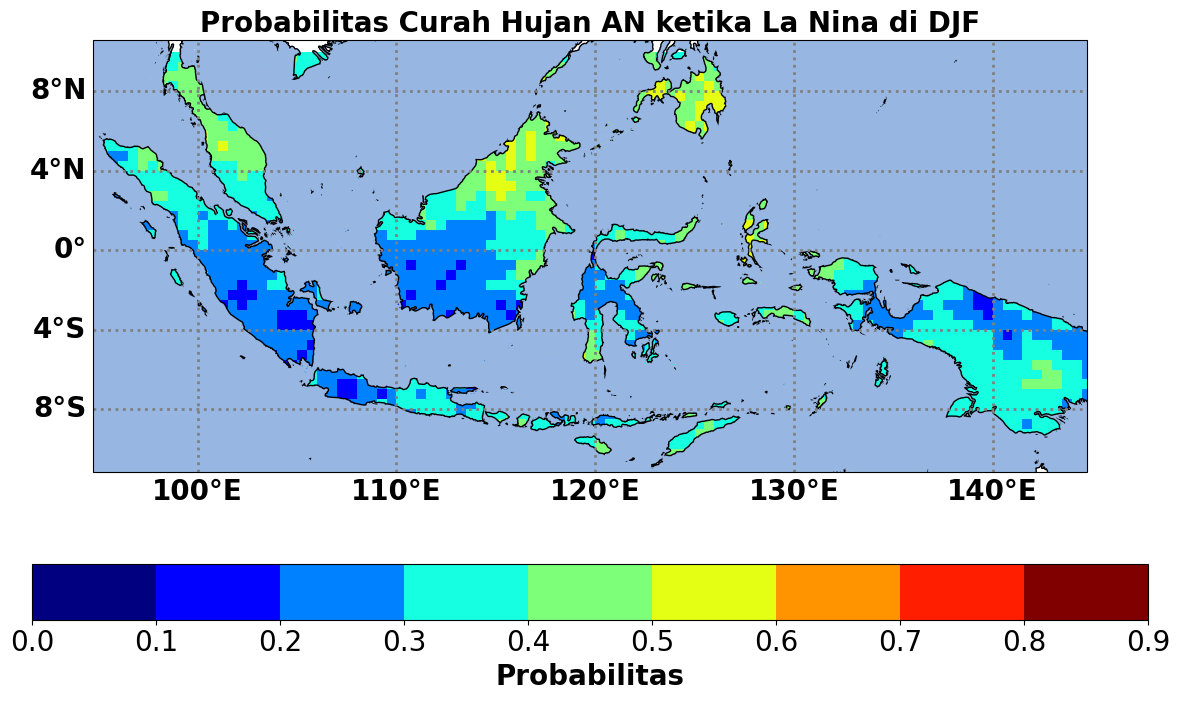

In [205]:
warnings.filterwarnings('ignore')

# Define projection of the map, may vary depends on location. See cartopy documentation for other projections.
mapProject = crt.crs.PlateCarree()

fig = plt.figure(figsize = (16,8))
axs = plt.axes(projection = mapProject)

# Plot the probability
plotData = probabilitySOI.plot(ax = axs,
                            transform = mapProject,
                            levels = np.arange(0.0, 1.0, 0.1),
                            cmap = 'jet',
                            cbar_kwargs = {'orientation':'horizontal', 'shrink':0.9})

# Additional features to help differ lands and oceans.
axs.set_title('Probabilitas Curah Hujan AN ketika La Nina di DJF', fontsize = 20, fontweight = 'bold')
axs.coastlines(resolution = '10m', linewidth = 2, edgecolor = 'black')
ocean = crt.feature.NaturalEarthFeature('physical', 'ocean', scale = '10m', edgecolor = 'none', facecolor = crt.feature.COLORS['water'])
axs.add_feature(ocean, linewidth = 0.2)

# Set the maximum drawing area based on coordinate boundaries
axs.set_extent([lon[0], lon[-1], lat[0], lat[-1]])

# Draw coordinate grids and hide duplicate labels
gridLines = plotData.axes.gridlines(draw_labels = True, linestyle = ':', linewidth = 2, color = 'gray')
gridLines.xlocator = mticker.FixedLocator([100, 110, 120, 130, 140])
gridLines.ylocator = mticker.FixedLocator([-8, -4, 0, 4, 8])
gridLines.xlabels_top = False
gridLines.xlabels_bottom = True
gridLines.ylabels_right = False
gridLines.ylabels_left = True
gridLines.xlabel_style = {'size':20, 'color':'black', 'weight':'bold'}
gridLines.ylabel_style = {'size':20, 'color':'black', 'weight':'bold'}


plotData.colorbar.ax.tick_params(labelsize = 20)
plotData.colorbar.set_label(label = 'Probabilitas', size = 20, weight = 'bold')

Visualization DMI

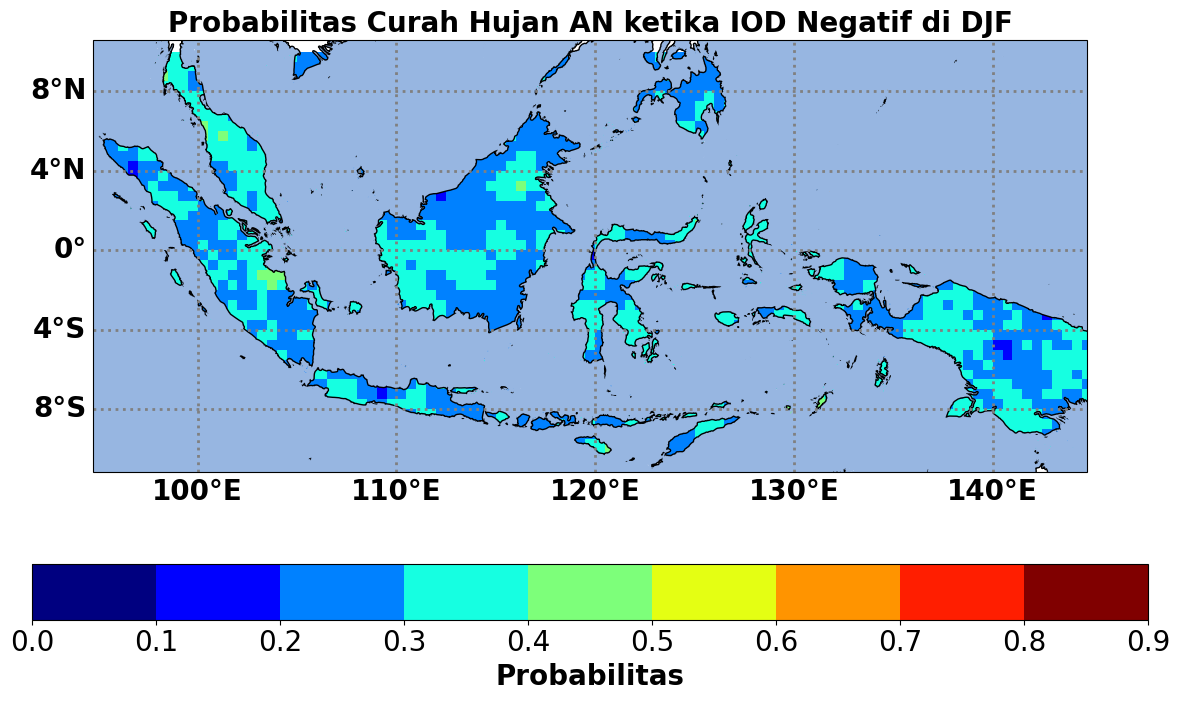

In [206]:
mapProject = crt.crs.PlateCarree()

fig = plt.figure(figsize = (16,8))
axs = plt.axes(projection = mapProject)

# Only this part is different from previous code
plotData = probabilityDMI.plot(ax = axs,
                            transform = mapProject,
                            levels = np.arange(0.0, 1.0, 0.1),
                            cmap = 'jet',
                            cbar_kwargs = {'orientation':'horizontal', 'shrink':0.9})

axs.set_title('Probabilitas Curah Hujan AN ketika IOD Negatif di DJF', fontsize = 20, fontweight = 'bold')
axs.coastlines(resolution = '10m', linewidth = 2, edgecolor = 'black')
ocean = crt.feature.NaturalEarthFeature('physical', 'ocean', scale = '10m', edgecolor = 'none', facecolor = crt.feature.COLORS['water'])
axs.add_feature(ocean, linewidth = 0.2)

axs.set_extent([lon[0], lon[-1], lat[0], lat[-1]])

gridLines = plotData.axes.gridlines(draw_labels = True, linestyle = ':', linewidth = 2, color = 'gray')
gridLines.xlocator = mticker.FixedLocator([100, 110, 120, 130, 140])
gridLines.ylocator = mticker.FixedLocator([-8, -4, 0, 4, 8])
gridLines.xlabels_top = False
gridLines.xlabels_bottom = True
gridLines.ylabels_right = False
gridLines.ylabels_left = True
gridLines.xlabel_style = {'size':20, 'color':'black', 'weight':'bold'}
gridLines.ylabel_style = {'size':20, 'color':'black', 'weight':'bold'}

plotData.colorbar.ax.tick_params(labelsize = 20)
plotData.colorbar.set_label(label = 'Probabilitas', size = 20, weight = 'bold')